# Example 2: Heuristic hyperparameters

We will use heuristic parameters to infer the posterior log-rate from an example dataset. The period of the grid can be inferred reasonably well from the radial autocorrelogram. The height of the kernel, reflecting the overall prior variance (uncertainty), is more difficult to infer. This heuristic estiamte of the prior variance is suitable for finding the locations of grid fields, but one should optimize it using the evidence lower bound (example 3) in order to get an interpretable posterior.

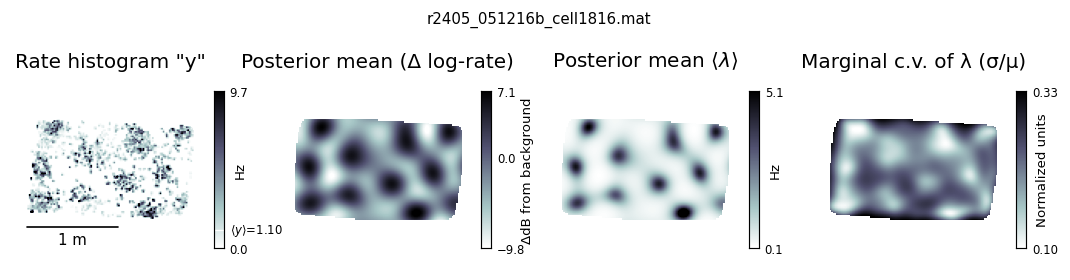

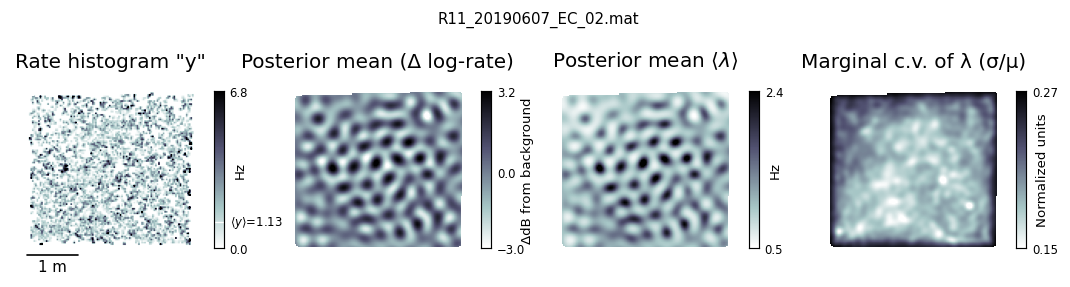

In [1]:
import sys
sys.path.append('../')
from lgcpspatial.load_data import Dataset
from lgcpspatial.lgcp2d    import DiagonalFourierLowrank, coordinate_descent
from lgcpspatial.plot      import inference_summary_plot

L        = 128 # Grid size for position bins
pad      = 0.1 # Edge padding (Avoids circular convolution wrap-around)
datadir  = '../example data/'
datasets = [
    'r2405_051216b_cell1816.mat',
    'R11_20190607_EC_02.mat'
]

for dataset in datasets:
    data = Dataset.from_file(datadir+dataset,pad)
    data.prepare(L,doplot=False)
    
    # Use heuristic kernel hyperparameters
    v0 = data.prior_variance
    P  = data.P
    
    # LGCP inference using heuristic parameters
    # - First set up the model
    # - Then infer the model
    model    = DiagonalFourierLowrank(v0,P,data)
    μh,v,nll = coordinate_descent(model,tol=1e-6)
    '''
    # For reference
    - μh  is in low-rank frequency space.    
    - v   is the marginal variances of each spatial bin
    - nll is the negative log model likelihood
    To recover the spatial means, you need to convert
    back to the spatial domain using model.F.T@μh and
    then add the prior mean μz:
        μ = model.F.T@μh+μz.ravel()
    The marginal mean and variance of the firing rate in Hz
    for each spatial bin follow from the moments of the 
    log-normal distribution:
        μλ = exp(μ+v/2).reshape(L,L)*Fs
        vλ = (exp(2*μ + v)*(exp(v)-1)).reshape(L,L)*Fs**2
        σλ = sqrt(vλ)
        cv = σλ/μλ
    '''
    inference_summary_plot(
        model,
        data.arena.mask,
        data.y,
        μh,
        data.prior_mean,
        v,
        data.position_sample_rate,
        L,
        data.scale,
        dataset)
    